In [1]:
%load_ext autoreload
%autoreload 2

from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy


from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pyha.common.util import *
from pyha.common.float import *

# FIR tests

In [2]:
class FIRFloat(Hardware):
    def __init__(self, taps):
        self.DELAY = 2

        self.TAPS = [Float(x) for x in np.array(taps).tolist()]
#         self.TAPS = np.array(taps).tolist()
        self.TAPS_ORIG = taps

        # registers
        self.acc = [Float()] * len(taps)
        self.mul = [Float()] * len(taps)
        # self.out = Float()

    def main(self, x):
        """ Transposed FIR structure """
        self.acc[0] = x * self.TAPS[-1]
        for i in range(1, len(self.acc)):
            self.mul[i] = x * self.TAPS[len(self.TAPS) - 1 - i]
            self.acc[i] = self.acc[i - 1] + self.mul[i]

        return self.acc[-1]

    def model_main(self, x):
        return signal.lfilter(self.TAPS_ORIG, [1.0], x)

In [3]:
np.random.seed(0)
taps = signal.remez(128, [0, 0.1, 0.155, 0.5], [1, 0])
# taps = signal.remez(511, [0, 0.4/2, 0.43/2, 1.0/2], [1, 0])
# taps = np.random.uniform(-1, 1, 256)
inp = np.random.uniform(-1, 1, 1024) / 2 /2 / 2 / 2 / 2 / 2 / 2
# inp = np.random.normal(scale=32, size=1024)

<IPython.core.display.Javascript object>


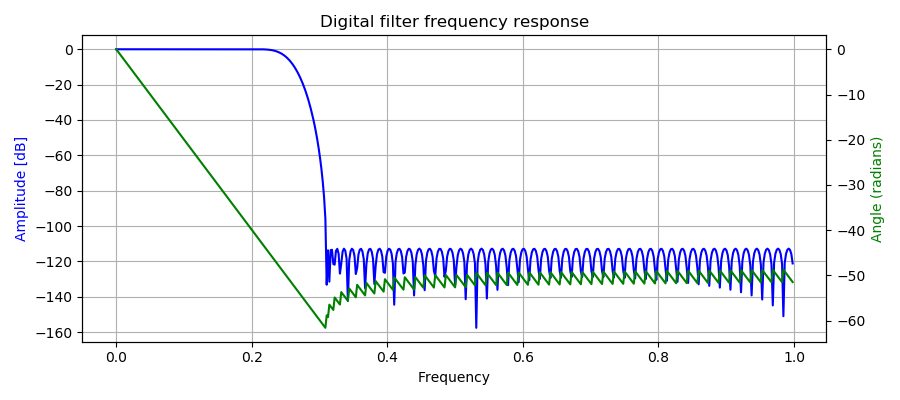

<IPython.core.display.Javascript object>


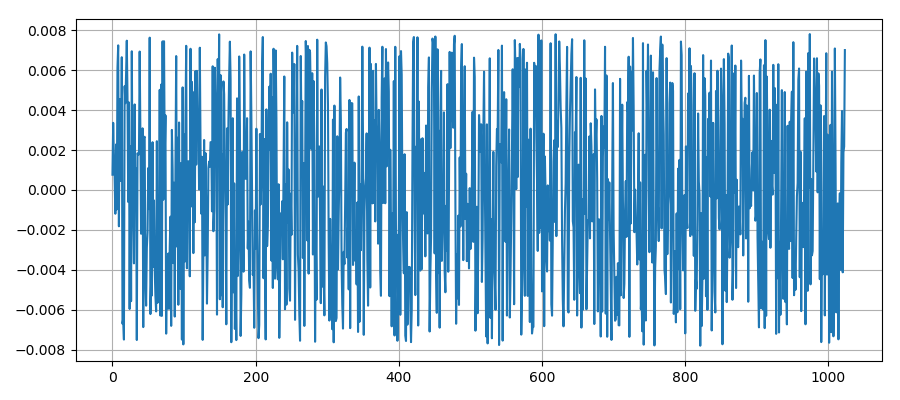

In [4]:
def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
show_freqz(taps)

plt.plot(inp)
show_plot()

In [5]:
results = {}

with force_format(radix=32, exponent_bits=3, fractional_bits=14):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['MODEL', 'PYHA'])
    results['Float64'] = np.array([float(x) for x in sims['MODEL']])
    results['Radix32'] = np.array([float(x) for x in sims['PYHA']])
#     results['RTL'] = np.array([float(x) for x in sims['RTL']])

with force_format(radix=16, exponent_bits=4, fractional_bits=14):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Radix16'] = np.array([float(x) for x in sims['PYHA']])

with force_format(float16_mode=True):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Float16'] = np.array([float(x) for x in sims['PYHA']])

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1026 [00:00<?, ?it/s]

  1%|          | 10/1026 [00:00<00:11, 88.72it/s]

  2%|▏         | 20/1026 [00:00<00:11, 91.30it/s]

  3%|▎         | 30/1026 [00:00<00:10, 93.12it/s]

  4%|▍         | 43/1026 [00:00<00:09, 101.39it/s]

  6%|▌         | 57/1026 [00:00<00:08, 108.62it/s]

  7%|▋         | 71/1026 [00:00<00:08, 112.92it/s]

  8%|▊         | 85/1026 [00:00<00:08, 115.56it/s]

 10%|▉         | 98/1026 [00:00<00:07, 116.68it/s]

 11%|█         | 110/1026 [00:00<00:07, 115.38it/s]

 12%|█▏        | 122/1026 [00:01<00:08, 112.58it/s]

 13%|█▎        | 134/1026 [00:01<00:07, 112.52it/s]

 14%|█▍        | 145/1026 [00:01<00:07, 111.29it/s]

 15%|█▌        | 158/1026 [00:01<00:07, 112.39it/s]

 17%|█▋        | 173/1026 [00:01<00:07, 114.43it/s]

 18%|█▊        | 186/1026 [00:01<00:07, 115.23it/s]

 19%|█▉        | 199/1026 [00:01<00:07, 115.24it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 33%|███▎      | 336/1026 [00:02<00:05, 119.89it/s]

 34%|███▍      | 351/1026 [00:02<00:05, 119.40it/s]

 36%|███▌      | 365/1026 [00:03<00:05, 119.05it/s]

 37%|███▋      | 380/1026 [00:03<00:05, 119.79it/s]

 38%|███▊      | 395/1026 [00:03<00:05, 120.54it/s]

 40%|███▉      | 410/1026 [00:03<00:05, 121.33it/s]

 42%|████▏     | 426/1026 [00:03<00:04, 122.09it/s]

 43%|████▎     | 440/1026 [00:03<00:04, 121.99it/s]

 44%|████▍     | 454/1026 [00:03<00:04, 122.47it/s]

 46%|████▌     | 468/1026 [00:03<00:04, 122.68it/s]

 47%|████▋     | 482/1026 [00:03<00:04, 122.31it/s]

 48%|████▊     | 495/1026 [00:04<00:04, 121.82it/s]

 50%|████▉     | 508/1026 [00:04<00:04, 121.70it/s]

 51%|█████     | 520/1026 [00:04<00:04, 121.25it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 65%|██████▍   | 664/1026 [00:05<00:02, 120.88it/s]

 66%|██████▌   | 677/1026 [00:05<00:02, 121.00it/s]

 67%|██████▋   | 691/1026 [00:05<00:02, 121.29it/s]

 69%|██████▊   | 704/1026 [00:05<00:02, 120.72it/s]

 70%|██████▉   | 718/1026 [00:05<00:02, 120.93it/s]

 71%|███████   | 731/1026 [00:06<00:02, 121.06it/s]

 73%|███████▎  | 745/1026 [00:06<00:02, 121.27it/s]

 74%|███████▍  | 759/1026 [00:06<00:02, 121.46it/s]

 76%|███████▌  | 775/1026 [00:06<00:02, 122.03it/s]

 77%|███████▋  | 789/1026 [00:06<00:01, 122.26it/s]

 78%|███████▊  | 804/1026 [00:06<00:01, 122.58it/s]

 80%|███████▉  | 820/1026 [00:06<00:01, 123.06it/s]

 81%|████████▏ | 836/1026 [00:06<00:01, 123.39it/s]

 83%|████████▎ | 851/1026 [00:06<00:01, 123.68it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 998/1026 [00:08<00:00, 122.19it/s]

 98%|█████████▊| 1010/1026 [00:08<00:00, 122.04it/s]

100%|█████████▉| 1022/1026 [00:08<00:00, 121.67it/s]

100%|██████████| 1026/1026 [00:08<00:00, 121.59it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



 11%|█         | 110/1026 [00:00<00:02, 359.50it/s]

 71%|███████   | 724/1026 [00:01<00:00, 396.98it/s]

 87%|████████▋ | 890/1026 [00:02<00:00, 397.97it/s]

100%|██████████| 1026/1026 [00:02<00:00, 396.60it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



100%|██████████| 1026/1026 [00:00<00:00, 1479.98it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


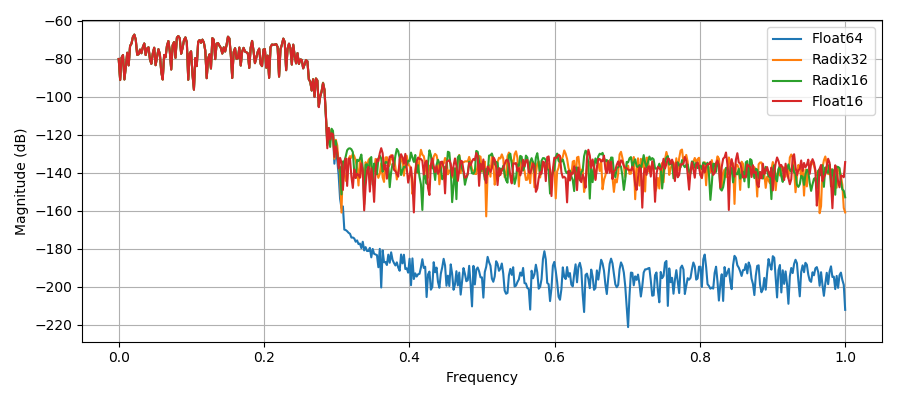

<IPython.core.display.Javascript object>


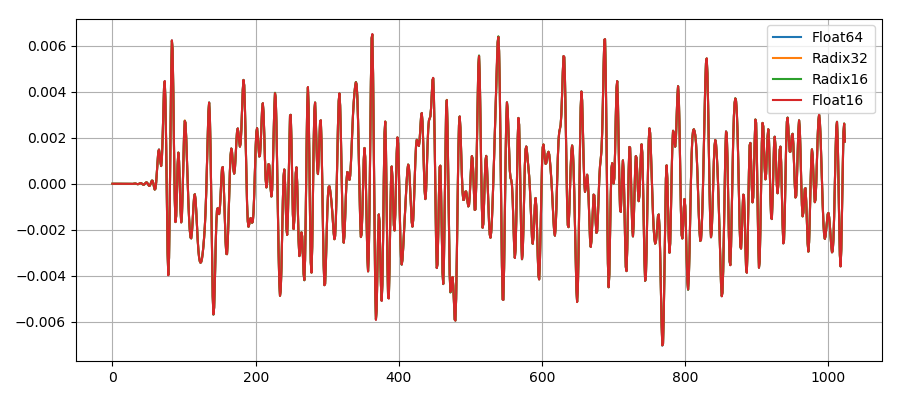

In [6]:
for key, val in results.items():
    plt.magnitude_spectrum(val, scale='dB', label=key)
show_plot()

for key, val in results.items():
    plt.plot(val, label=key)
show_plot()

<IPython.core.display.Javascript object>


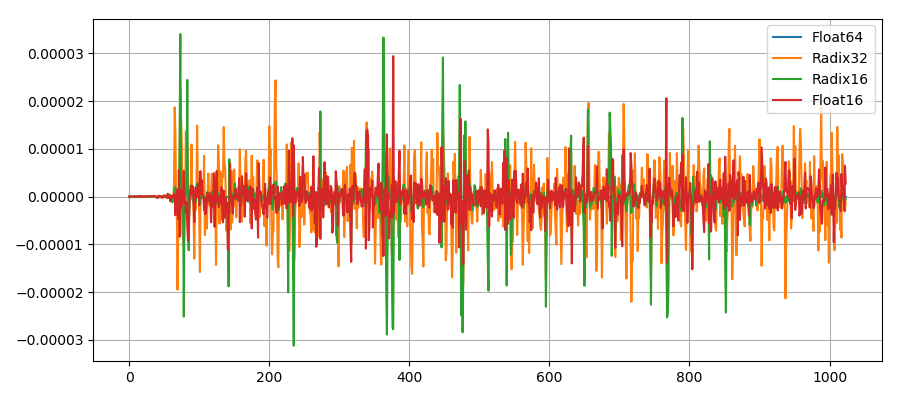

Float64 SNR: inf dB
Radix32 SNR: 52.34597487470723 dB
Radix16 SNR: 59.41747605154221 dB
Float16 SNR: 57.76928545755317 dB


/home/gaspar/git/pyha/pyha/common/util.py:109: RuntimeWarning: divide by zero encountered in double_scalars
  snr_db = 20 * np.log10(sig_pow / err_pow)


In [7]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=key)
show_plot()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)